<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

Для быстрого выполнения просмотрите [семинар](https://drive.google.com/file/d/1w_rTEWXQ_SA4YPXFjpkM0aU51bDgWLyI/view?usp=sharing).


### Models: Sentence Sentiment Classification
Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). We can think of it as looking like this:

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.


<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

## Dataset
The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):


<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>

## Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.3 MB/s 
     |████████████████████████████████| 7.6 MB 23.3 MB/s 
     |████████████████████████████████| 182 kB 48.3 MB/s 


[Transformers library doc](https://huggingface.co/transformers/)

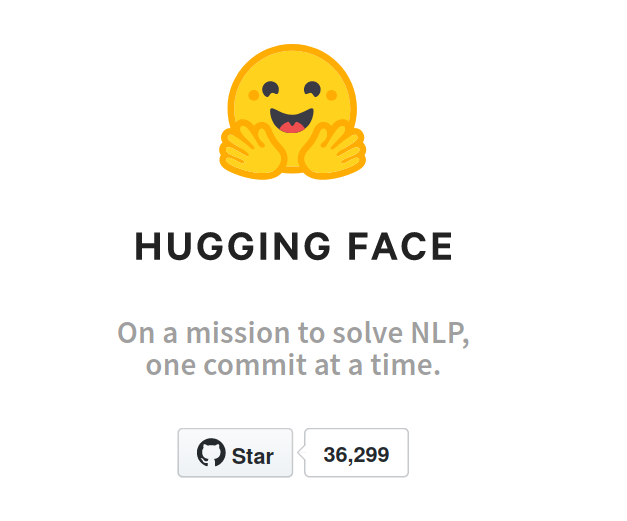

In [2]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb

import gc
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Будем сохранять на Google disk промежуточные результаты

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Чтобы сохранять результаты в свою папку на Google disk
%cd ./drive/MyDrive/DLS_NLP/6w_transformers/

/content/drive/MyDrive/DLS_NLP/6w_transformers


### Importing the dataset

In [ ]:
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
print(df.shape)
df.sample(5)

(6920, 2)


,0,1
3633,the filmmakers ' eye for detail and the high s...,1
5019,a fascinating glimpse into an insular world th...,1
4718,"finally , the french produced `` read my lips ...",1
6092,"lasker 's canny , meditative script distances ...",1
5238,the extent to which it succeeds is impressive,1


In [ ]:
# Проверим баланс классов
df[1].value_counts()

1    3610
0    3310
Name: 1, dtype: int64

### Using BERT for text classification.

Let's now load a pre-trained BERT model. 

In [ ]:
# For DistilBERT, Load pretrained model/tokenizer:

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

In [ ]:
# look at the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [ ]:
from termcolor import colored

colors = ['red', 'green', 'blue', 'yellow']

def model_structure(layer, margin=0, item_color=0):
    for name, next_layer in layer.named_children():

        next = (0 if not list(next_layer.named_children()) else 1)
        print(colored(' ' * margin + name, colors[item_color]) + ':' * next)
        model_structure(next_layer, margin + len(name) + 2, (item_color + 1) % 4)

model_structure(model)

embeddings:
            word_embeddings
            position_embeddings
            LayerNorm
            dropout
transformer:
             layer:
                    0:
                       attention:
                                  dropout
                                  q_lin
                                  k_lin
                                  v_lin
                                  out_lin
                       sa_layer_norm
                       ffn:
                            dropout
                            lin1
                            lin2
                            activation
                       output_layer_norm
                    1:
                       attention:
                                  dropout
                                  q_lin
                                  k_lin
                                  v_lin
                                  out_lin
                       sa_layer_norm
                       ffn:
                   

### Preparing the dataset

In [ ]:
from torch.utils.data import Dataset, random_split

class ReviewsDataset(Dataset):
    def __init__(self, reviews, tokenizer, labels):
        self.labels = labels
        # tokenized reviews
        self.tokenized = reviews.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
        
    def __getitem__(self, idx):
        return {"tokenized": self.tokenized[idx], "label": self.labels[idx]}

    def __len__(self):
        return len(self.labels)

dataset = ReviewsDataset(df[0], tokenizer, df[1])

# DON'T CHANGE, PLEASE
train_size, val_size = int(.8 * len(dataset)), int(.1 * len(dataset))
torch.manual_seed(2) 
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 5536
Number of validation examples: 692
Number of testing examples: 692


In [ ]:
from torch.utils.data import Sampler

class ReviewsSampler(Sampler):
    def __init__(self, subset, batch_size=32):
        self.batch_size = batch_size
        self.subset = subset

        self.indices = subset.indices
        # tokenized for our data
        self.tokenized = np.array(subset.dataset.tokenized)[self.indices]

    def __iter__(self):

        batch_idx = []
        # index in sorted data
        for index in np.argsort(list(map(len, self.tokenized))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.dataset)

In [ ]:
from torch.utils.data import DataLoader

def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])

    return padded

def collate_fn(batch):

    inputs = []
    labels = []
    for elem in batch:
        inputs.append(elem['tokenized'])
        labels.append(elem['label'])

    inputs = get_padded(inputs)
    attention_mask = np.where(inputs != 0, 1, 0)

    return {"inputs": torch.tensor(inputs), "labels": torch.FloatTensor(labels), "attention_mask" : torch.tensor(attention_mask)}

train_loader = DataLoader(train_data, batch_sampler=ReviewsSampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=ReviewsSampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=ReviewsSampler(test_data), collate_fn=collate_fn)

### Baseline

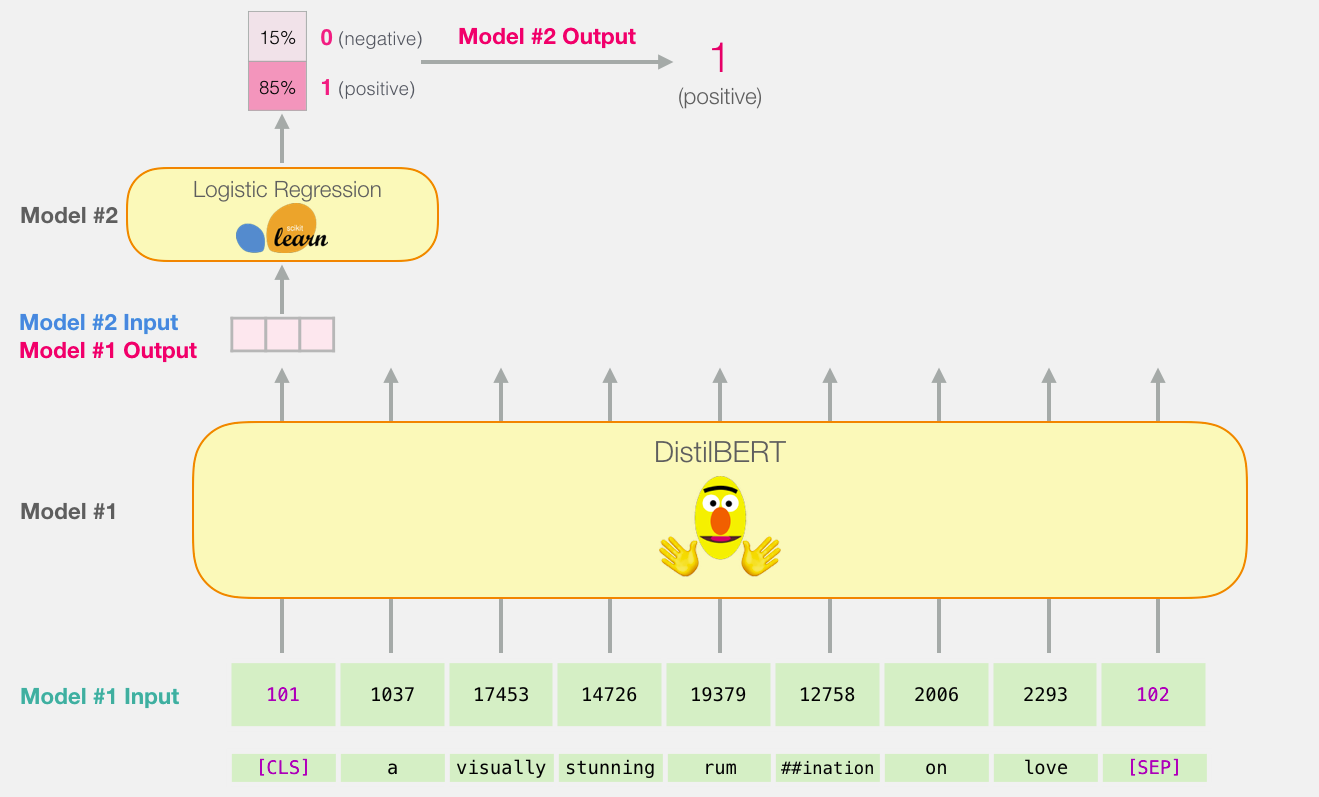

In [ ]:
from tqdm.notebook import tqdm

def get_xy(loader):
    features = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            input = batch["inputs"].to(device)
            mask = batch["attention_mask"].to(device)
            last_hidden_states = model(input, attention_mask=mask)
            
            features.append(last_hidden_states[0].cpu())
            labels.append(batch["labels"].cpu())

    features = torch.cat([elem[:, 0, :] for elem in features], dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    return features, labels

In [ ]:
train_features, train_labels = get_xy(train_loader)
valid_features, valid_labels = get_xy(valid_loader)
test_features, test_labels = get_xy(test_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
# Для тренировки логистической регрессии GPU не нужен. 
# Сохраним train и test на Goggle disk

import pickle

dct_feat_lab = {'train_features': train_features,
                'train_labels': train_labels,
                'test_features': test_features,
                'test_labels': test_labels
}

with open('train_test_features.pickle', 'wb') as handle:
    pickle.dump(dct_feat_lab, handle)

In [ ]:
import pickle
with open('train_test_features.pickle', 'rb') as handle:
    dct_feat_lab = pickle.load(handle)

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(dct_feat_lab['train_features'], dct_feat_lab['train_labels'])
lr_clf.score(dct_feat_lab['test_features'], dct_feat_lab['test_labels'])

0.8179190751445087

Попробуем улучшить результат

In [ ]:
log_reg = LogisticRegression(random_state=1, max_iter=1000, n_jobs=-1)
parameters = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]
    }
clf = GridSearchCV(
    log_reg, 
    parameters,
    cv=3,
    refit=True,
    n_jobs=-1,
    scoring='accuracy',
    return_train_score=True
    )
clf.fit(dct_feat_lab['train_features'], dct_feat_lab['train_labels'])

In [ ]:
clf.score(dct_feat_lab['test_features'], dct_feat_lab['test_labels'])

0.8164739884393064

Accuracy не удалось улучшить с помощью подбора параметров логистической регрессии

### Fine-Tuning BERT

Define the model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.autonotebook import tqdm

In [ ]:
from torch import nn

class BertClassifier(nn.Module):
    def __init__(self, pretrained_model, dropout=0.1):
        super().__init__()

        self.bert = pretrained_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(8, stride=2)
        self.conv_0 = nn.Sequential(
             nn.Conv1d(in_channels=1, out_channels=64, kernel_size=16),
             nn.BatchNorm1d(64)
            )
        self.conv_1 = nn.Sequential(
             nn.Conv1d(in_channels=64, out_channels=132, kernel_size=16),
             nn.BatchNorm1d(132)
            )
        self.conv_2 = nn.Sequential(
             nn.Conv1d(in_channels=132, out_channels=64, kernel_size=16),
             nn.BatchNorm1d(64)
            )
        self.conv_3 = nn.Conv1d(in_channels=64, out_channels=1, kernel_size=8)
        self.fc = nn.Linear(32, 1)
    
    def forward(self, inputs, attention_mask):
        inp = self.bert(inputs, attention_mask=attention_mask)[0][:, 0, :].unsqueeze(1)
        inp = self.pool(self.relu(self.conv_0(inp)))
        inp = self.pool(self.relu(self.conv_1(inp)))
        inp = self.pool(self.relu(self.conv_2(inp)))
        inp = self.pool(self.relu(self.conv_3(inp))).squeeze(1)
        inp = self.fc(self.dropout(inp)).squeeze(1)
        proba = F.sigmoid(inp)
        return proba

In [ ]:
import torch.optim as optim

# DON'T CHANGE
model = model_class.from_pretrained(pretrained_weights).to(device)
bert_clf = BertClassifier(model).to(device)
# you can change
optimizer = optim.Adam(bert_clf.parameters(), lr=2e-5)
criterion = nn.BCELoss()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(bert_clf):,} trainable parameters')

The model has 66,635,566 trainable parameters


In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, train_acc_hist=None, valid_acc_hist=None):
    model.train()
    
    epoch_loss = 0
    history = []
    epoch_acc = 0
    epoch_nums = 0
    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        input = batch["inputs"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device) 
        output = model(input, attention_mask=mask)

        loss = criterion(output, labels) 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        output = output.detach().cpu() > 0.5
        epoch_acc += (output == labels.cpu()).float().sum().item()
        epoch_nums += len(labels.cpu())

        history.append(loss.cpu().data.numpy())
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 8))
    clear_output(True)
    ax[0].plot(history, label='train loss')
    ax[0].set_xlabel('Batch')
    ax[0].set_title('Train loss')
    ax[0].legend() 
    if train_history is not None:
        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
        ax[1].legend() 
    if valid_history is not None:
        ax[1].plot(valid_history, label='general valid history')
        ax[1].legend() 
    if train_acc_hist is not None:
        ax[2].plot(train_acc_hist, label='train accuracy history')
        ax[2].set_xlabel('Epoch')
        ax[2].legend() 
    if valid_acc_hist is not None:
        ax[2].plot(valid_acc_hist, label='valid accuracy history')
        ax[2].legend() 
    plt.show()
        
    return epoch_loss / (i + 1), epoch_acc / epoch_nums

def evaluate(model, iterator, criterion):
    
    model.eval()    
    epoch_loss = 0
    epoch_acc = 0
    epoch_nums = 0
    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            input = batch["inputs"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device) 
            output = model(input, attention_mask=mask)

            loss = criterion(output, labels)
            
            epoch_loss += loss.item()
            output = output.detach().cpu() > 0.5
            epoch_acc += (output == labels.cpu()).float().sum().item()
            epoch_nums += len(labels.cpu())
        
    return epoch_loss / (i + 1), epoch_acc / epoch_nums

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import math
import time

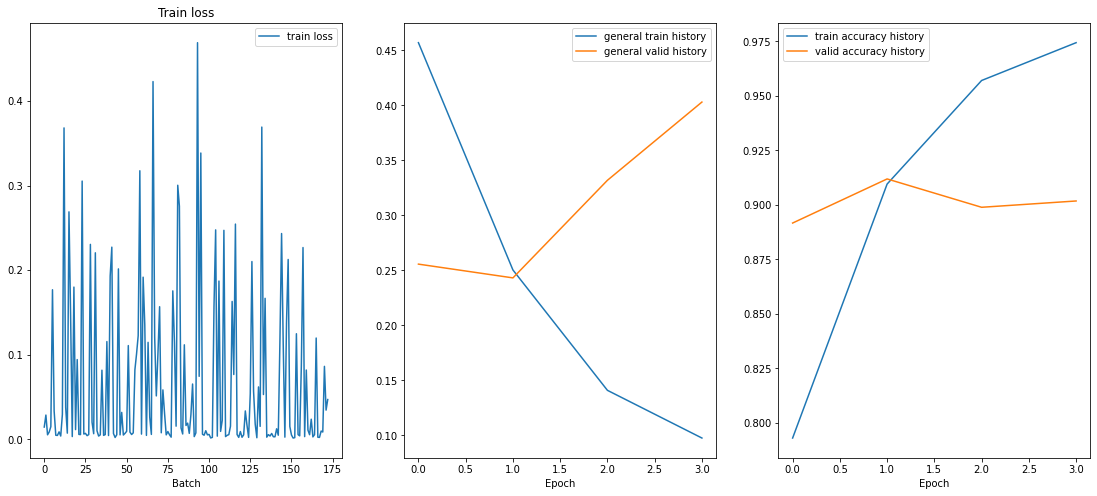

Epoch: 05 | Time: 0m 18s
	Train Loss: 0.068 | Train PPL:   1.070
	 Val. Loss: 0.549 |  Val. PPL:   1.732
	 Train. Acc: 0.982 |  Val. Acc: 0.893


In [ ]:
train_history = []
valid_history = []
train_acc_hist = []
valid_acc_hist = []

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(N_EPOCHS):    
    start_time = time.time()
    
    train_loss, train_acc = train(bert_clf, train_loader, optimizer, criterion, CLIP, train_history, valid_history, train_acc_hist, valid_acc_hist)
    valid_loss, valid_acc = evaluate(bert_clf, valid_loader, criterion)
    
    end_time = time.time()    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_clf.state_dict(), 'best-loss-model.pt')

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(bert_clf.state_dict(), 'best-acc-model.pt')    
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    train_acc_hist.append(train_acc)
    valid_acc_hist.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'\t Train. Acc: {train_acc:.3f} |  Val. Acc: {valid_acc:.3f}')
    gc.collect()
    torch.cuda.empty_cache()

torch.save(bert_clf.state_dict(), 'last-model.pt') 

In [ ]:
best_model = BertClassifier(model).to(device)
best_model.load_state_dict(torch.load('best-acc-model.pt'))

pred_labels = []
true_labels = []

best_model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):
        input = batch["inputs"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"]
        output = best_model(input, attention_mask=mask)

        output = output.cpu() > 0.5
        pred_labels.append(output.numpy())
        true_labels.append(labels.numpy())

0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)
test_accuracy = accuracy_score(true_labels, pred_labels)

In [ ]:
print('Accuracy на тестовой выборке =', round(test_accuracy, 3))

Accuracy на тестовой выборке = 0.879


In [ ]:
assert test_accuracy >= 0.86

### Finetuned model from **HUGGING FACE**

[BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertfor#transformers.BertForSequenceClassification)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# we have the same tokenizer
# new_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
new_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english").to(device)

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
new_model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

In [ ]:
print(f'The model has {count_parameters(new_model):,} trainable parameters')

The model has 66,955,010 trainable parameters


In [ ]:
pred_labels = []
true_labels = []

new_model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):
        input = batch["inputs"].to(device)
        mask = batch["attention_mask"].to(device)
        out = new_model(input, attention_mask=mask).logits.argmax(dim=1)
            
        pred_labels.append(out.cpu())
        true_labels.append(batch["labels"].cpu())

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)
accuracy_score(true_labels, pred_labels)

0it [00:00, ?it/s]

0.9841040462427746

In [ ]:
model_structure(new_model)

distilbert:
            embeddings:
                        word_embeddings
                        position_embeddings
                        LayerNorm
                        dropout
            transformer:
                         layer:
                                0:
                                   attention:
                                              dropout
                                              q_lin
                                              k_lin
                                              v_lin
                                              out_lin
                                   sa_layer_norm
                                   ffn:
                                        dropout
                                        lin1
                                        lin2
                                        activation
                                   output_layer_norm
                                1:
                                   attention:


## Напишите вывод о своих результатах. В выводы включите ваши гиперпараметры. 

*Качество с помощью Fine-Tuning должно достигать 0.86.*



* BERT + логистическая регрессия. Best accuracy: 0.818
  - Параметры логистической регрессии по умолчанию (GridSearch не дал прироста качеству):
```
 {'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'tol': 0.0001,
 'warm_start': False}
```
* BERT + СNN. Best accuracy: 0.879
  - 66,635,566 параметров
  - В качестве дополнения к BERT использовались 4 сверточных слоя (Conv1d) с макспуллингами (MaxPool1d) и 1 полносвязный слой (Linear). Перед полносязным слоем стоит Dropout = 0.1
  - Каждый сверточный слой имеет kernel_size=16 (последний kernel_size=8)
  - MaxPool1d(8, stride=2)
  - После каждого сверточного слоя использовались BatchNorm и активация ReLU
  - Качество модели не стабильно. Я запускала несколько раз и не на всех итерациях получала accuracy > 0.86
  - Думаю, что можно улучшить качество. График loss на каждом батче напоминает кардиограмму, а после 3 эпохи модель начинает переобучаться.
      - warmup (может быть)
      - Уменьшить learning rate
      - Уменьшить / увеличить количество слоев
      - Комбинировать свертки и линейные слои
      - Попробовать другие размеры кернелов
      - Уменшить / увеличить размер батча 
  - pretrained BERT имеет следующую конфигруацию:   
```
 DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}
```

* BertForSequenceClassification. Best accuracy: 0.984
  - 66,955,010 параметров
  - Если я правильно поняла документацию, то в качестве дополнения к BERT используется BertPooler (линейный слой без изменения размера с активацией Tanh  + 1 линейный слой с Dropout. 
  - Модель имеет следующую кофигурацию: 
```
DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}
```

Насколько я понимаю, выбранная натренированная модель обучалась на тех же данных, на которых мы сейчас ее проверяем. Написанная мной модель (точнее классификационная часть модели) на Train показывает такую же точность. Прежде чем делать окончательные выводы, какая модель лучше, следует внимательнее изучить и разницу в архитектуре и особенности тренировки.

